<a href="https://colab.research.google.com/github/Marcelle-git/DeepLearningTask/blob/main/Task_1_Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd              #Import the libraries
import matplotlib.pyplot as plt

In [ ]:
data=pd.read_csv('/content/DataTask1Deeplearning.csv')


In [ ]:
data.head()
#data.info()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


DATA CLEANING


In [ ]:
null_count = data.isnull().sum().sum()        #checking missing values
print('Number of null values:', null_count)

Number of null values: 0


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
date= data['Date']                             #converting data types
data = data.set_index('Date')                  # Applying the set_index method
print(data)


             Source    Mean
Date                       
2016-12-06     GCAG  0.7895
2016-12-06  GISTEMP  0.8100
2016-11-06     GCAG  0.7504
2016-11-06  GISTEMP  0.9300
2016-10-06     GCAG  0.7292
...             ...     ...
1880-03-06  GISTEMP -0.1800
1880-02-06     GCAG -0.1229
1880-02-06  GISTEMP -0.2100
1880-01-06     GCAG  0.0009
1880-01-06  GISTEMP -0.3000

[3288 rows x 2 columns]


In [ ]:
data.drop(columns=['Source'])    #dropping unnecessary columns


,Mean
Date,
2016-12-06,0.7895
2016-12-06,0.8100
2016-11-06,0.7504
2016-11-06,0.9300
2016-10-06,0.7292
...,...
1880-03-06,-0.1800
1880-02-06,-0.1229
1880-02-06,-0.2100


In [ ]:
data_new=data[['Mean']].resample('M').sum()      #Resampling data for having global monthly mean temperature instead of daily

<Axes: xlabel='Date'>

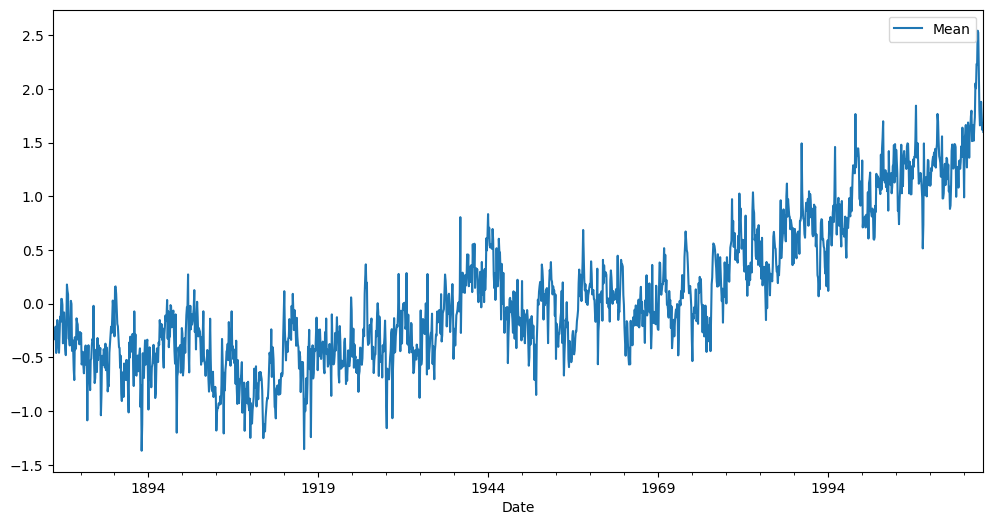

In [ ]:
data_new.plot(figsize=(12,6))                    #Quick vizualisation of the monthly mean temperature

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

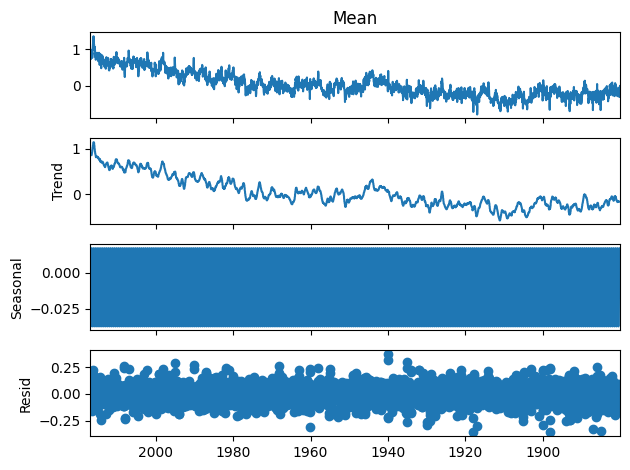

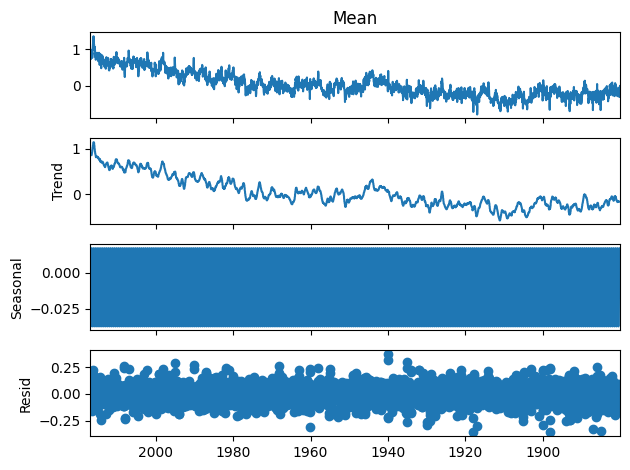

In [ ]:
results=seasonal_decompose(data['Mean'], period=12)

results.plot()

Data preparation and feature engineering

In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def create_sliding_window(data, sequence_length, stride=1):          #Sliding window is a feature engineering method which consist into adding lag features for spoting patterns
    X_list, y_list = [], []
    for i in range(len(data)):
      if (i + sequence_length) < len(data):
        X_list.append(data.iloc[i:i+sequence_length:stride, :].values)
        y_list.append(data.iloc[i+sequence_length, -1])
    return np.array(X_list), np.array(y_list)

train_split = 0.7
n_train = int(train_split * len(data_new))
n_test = len(data_new) - n_train

features = ['Mean']
feature_array = data_new[features].values

#Now,we are going to apply normalization on column 'mean' because it hasn't a gaussian distribution,without this,the accuracy or the performance of the model can be affected

# Fit Scaler only on Training features
feature_scaler = MinMaxScaler()
feature_scaler.fit(feature_array[:n_train])
# Fit Scaler only on Training target values
target_scaler = MinMaxScaler()
target_scaler.fit(feature_array[:n_train, -1].reshape(-1, 1))

# Transfom on both Training and Test data
scaled_array = pd.DataFrame(feature_scaler.transform(feature_array),
                            columns=features)

sequence_length = 10
X, y = create_sliding_window(scaled_array,
                             sequence_length)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
X_train= X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1150, 1, 10) (1150,) (484, 1, 10) (484,)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Bidirectional
from keras.layers import Dropout

Model Architecture

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(LSTM(units=50))
model.add(Dropout(0.2))         #Dropout is a technique which allow us to avoid overfitting of the model during the training
#    model.add(LSTM(70))
#    model.add(Dropout(0.3)) is an example of tweak that we can perform for improving the prediction of our model
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')  #Our loss function is the Mean Squared Error and we choose the Adaptive Moment Estimation (Adam) as optimizer

In [ ]:
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error

Training of the model and choice of the hyperparameters

Epoch 1/70
23/23 - 9s - loss: 0.1663 - val_loss: 0.2394 - 9s/epoch - 388ms/step
Epoch 2/70
23/23 - 0s - loss: 0.0178 - val_loss: 0.0305 - 121ms/epoch - 5ms/step
Epoch 3/70
23/23 - 0s - loss: 0.0152 - val_loss: 0.0237 - 128ms/epoch - 6ms/step
Epoch 4/70
23/23 - 0s - loss: 0.0141 - val_loss: 0.0261 - 123ms/epoch - 5ms/step
Epoch 5/70
23/23 - 0s - loss: 0.0134 - val_loss: 0.0186 - 124ms/epoch - 5ms/step
Epoch 6/70
23/23 - 0s - loss: 0.0125 - val_loss: 0.0155 - 114ms/epoch - 5ms/step
Epoch 7/70
23/23 - 0s - loss: 0.0130 - val_loss: 0.0117 - 162ms/epoch - 7ms/step
Epoch 8/70
23/23 - 0s - loss: 0.0127 - val_loss: 0.0102 - 123ms/epoch - 5ms/step
Epoch 9/70
23/23 - 0s - loss: 0.0128 - val_loss: 0.0097 - 125ms/epoch - 5ms/step
Epoch 10/70
23/23 - 0s - loss: 0.0112 - val_loss: 0.0096 - 119ms/epoch - 5ms/step
Epoch 11/70
23/23 - 0s - loss: 0.0108 - val_loss: 0.0092 - 120ms/epoch - 5ms/step
Epoch 12/70
23/23 - 0s - loss: 0.0107 - val_loss: 0.0095 - 128ms/epoch - 6ms/step
Epoch 13/70
23/23 - 0s - l

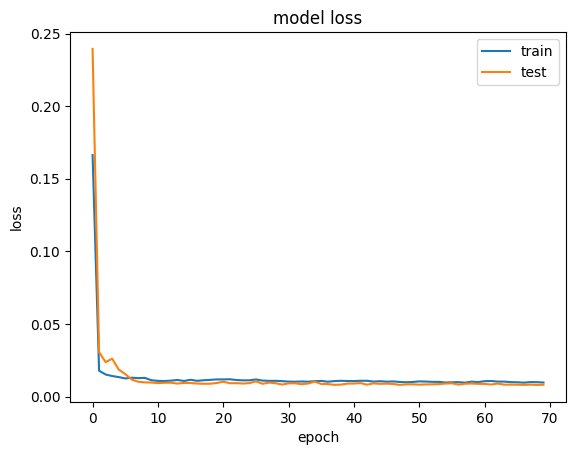

16/16 [==============================] - 2s 2ms/step
Test RMSE: 0.199


Text(0.5, 1.0, 'Actual')

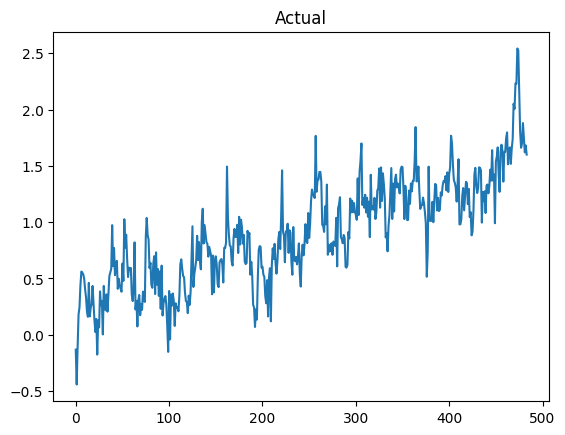

In [ ]:
# fit network
history = model.fit(X_train, y_train, epochs=70, batch_size=50, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# make a prediction
y_test_predict = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], 10))
# invert scaling for forecast
inv_y_test_predict = feature_scaler.inverse_transform(np.concatenate((y_test_predict, X_test[:, -6:]), axis=1))
inv_y_test_predict = inv_y_test_predict[:,0]
# invert scaling for actual
y_test= y_test.reshape((len(y_test), 1))
inv_y = feature_scaler.inverse_transform(np.concatenate((y_test, X_test[:, -6:]), axis=1))
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_test_predict))
print('Test RMSE: %.3f' % rmse)



plt.plot(inv_y)
plt.title('Actual')


Text(0.5, 1.0, 'Prediction')

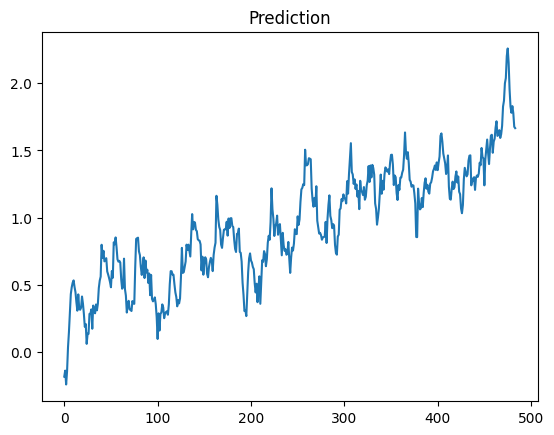

In [ ]:
plt.plot(inv_y_test_predict)
plt.title('Prediction')